# scRNA-seq: B lymphocytes treated with a novel IL-10 inducer

## --- Differential expression ---

## Table of contents:

  * <a href=#Reading>1 Reading in the data</a>
  * <a href=#Preprocessing>2 Pre-processing and visualization</a>
    * <a href=#QC>2.1 Quality Control</a>

# 0. Loading the libraries

[Timing: 50s]

In [9]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb
import gseapy as gp
from gseapy.plot import barplot, dotplot

from pyorthomap import findOrthologsHsMm
#import diffxpy.api as de
#from bioinfokit import analys, visuz
#import xlsxwriter

import normalisr.normalisr as norm
import statsmodels
from adjustText import adjust_text

from itertools import compress

import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

# 1. Reading in the data

In [3]:
# Load the pre-processed data

with open('saved_objects/adata_annotated.pkl', 'rb') as inp:
    adata = pickle.load(inp)

In [4]:
diseases = ["ms", "pr", "crohn", "t1d", "sle"]
GWAS_tmp = []

for disease in diseases:
    gwas_file = "GWAS/"+disease+".tsv"
    gwas_list = pd.read_csv(gwas_file, header = 0, sep = "\t")[["REPORTED GENE(S)", "PVALUE_MLOG"]]
    genes = []
    for gene in gwas_list["REPORTED GENE(S)"].tolist():
        if str(gene) not in ['nan', 'intergenic', 'NR', 'Intergenic']:
            if len(gene.split(',')) == 1:
                genes.append(gene)
            else:
                genes.append(gene.split(',')[0])
    GWAS_tmp.append(list(set(genes)))

In [12]:
def replace(x):
    if len(x.tolist()) == 1:
        if x.tolist()[0] != x.tolist()[0]:
            return "NA"
        else:
            return(x.tolist()[0])
    else:
        return "NA"

def convert_genes(lgenes):
    translated = findOrthologsHsMm(from_filters = 'hgnc_symbol',
                  from_values = lgenes).map()
    return [replace(translated[translated.external_gene_name == e]["external_gene_name"]) for e in adata.var['gene_name']]

GWAS = {}
for i in range(len(diseases)):
    GWAS[diseases[i]] = convert_genes(GWAS_tmp[i])

# add sp140
GWAS['crohn'].extend(['Sp140', 'Sp110'])
GWAS['ms'].extend(['Sp140'])
GWAS['pr'].extend(['Sp140'])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
tf_file1 = 'files/mm_mgi_tfs.txt'
tf_list1 = pd.read_table(tf_file1, delimiter='\t', header=None).rename(columns={0:"Symbol"})
tf_file2 = 'files/Mus_musculus_TF.txt'
tf_list2 = pd.read_table(tf_file2, delimiter='\t')
tf_list = pd.concat([tf_list1,tf_list2]).drop_duplicates().reset_index(drop=True).Symbol

In [15]:
atacD2_D3 = pd.read_table("files/D2_D3_DARs_GeneMerged.txt", sep = "\t")
atacD2_D3 = atacD2_D3[["GeneSymbol", "annotation"]]
atacD2_D3.columns = ['gene', 'annotation']

atacD2_D3_D7 = pd.read_table("files/D2_D3_D7_DARs_GeneMerged.txt", sep = "\t")
atacD2_D3_D7 = atacD2_D3_D7[["GeneSymbol", "annotation"]]
atacD2_D3_D7.columns = ['gene', 'annotation']

## 2 Marker Co-expression

## 2.1 IL-10

In [16]:
MARKER = "Il10"

In [17]:
# Inputs for normalisr

dt0 = adata.raw.X[:, [not(gene.startswith(("mt-", 'Rps', "Rpl"))) for gene in adata.var['gene_name']]].T
dc0 = np.array(adata.obs[["n_counts", "n_genes"]]).T

In [18]:
# Normalisation for normalisr
dt,_,_,dc2 = norm.lcpm(dt0)
dc=np.concatenate([dc0,dc2],axis=0)
dc=norm.normcov(dc)
sf=norm.scaling_factor(dt0)
weight=norm.compute_var(dt,dc)
dt,dc=norm.normvar(dt,dc,weight,sf)

In [19]:
filt = [not(gene.startswith(("mt-", 'Rps', "Rpl"))) for gene in adata.var['gene_name']]
gene_names = adata.var.gene_name[filt]

In [22]:
a = 0.99999999999999
coex_list = []
samp_list = ['NAIVE-0h', 'DMSO-2h', 'DMSO-24h', 'DMSO-48h', 'DMSO-d7', 'N6-2h', 'N6-24h' , 'N6-48h', "N6-d7"]

for samp in samp_list: 

    print(samp)

    dt_samp = dt[:, adata.obs['sample2'] == samp]
    dc_samp = dc[:, adata.obs['sample2'] == samp]

    co = norm.coex(dt_samp, dc_samp)
    co_pval = pd.DataFrame(co[0], index = gene_names, columns = gene_names)
    co_mean = pd.DataFrame(co[1], index = gene_names, columns = gene_names)

    bi = norm.binnet(co[0], a)
    bi_ = pd.DataFrame(bi, index = gene_names, columns = gene_names)

    sig_pval = co_pval[MARKER][bi_[MARKER]]
    sig_mean = co_mean[MARKER][bi_[MARKER]]

    res = pd.DataFrame({"pval" : sig_pval, "mean" : sig_mean})
    coex_list.append(res)


NAIVE-0h


KeyboardInterrupt: 

In [ ]:
coex_result = []

for i in range(len(coex_list)):
    print(samp_list[i])

    results = coex_list[i]
    results["qval"] = list(statsmodels.stats.multitest.multipletests(list(results["pval"]), method='fdr_bh', is_sorted=False, returnsorted=False)[1])
    results["gene"] = gene_names
    results = results[['gene', 'pval', 'qval', 'mean']]

    results = results.sort_values(by="qval", ascending=True)
    results.reset_index(drop=True, inplace=True)
    results.index.name = 'pval rank'
    results = results.sort_values(by="mean", ascending=False)

    coex_result.append(results)

NAIVE-0h
DMSO-2h
DMSO-24h
DMSO-48h
DMSO-d7
N6-2h
N6-24h
N6-48h
N6-d7


In [ ]:
save_object(coex_result, "saved_objects/coex_list.pkl")

In [ ]:
with open('saved_objects/coex_list.pkl', 'rb') as inp:
    coex_result = pickle.load(inp)

samp_list = ['NAIVE-0h', 'DMSO-2h', 'DMSO-24h', 'DMSO-48h', 'DMSO-d7', 'N6-2h', 'N6-24h' , 'N6-48h', "N6-d7"]

In [ ]:
qthresholds = []

for res in range(len(coex_result)):

    result = coex_result[res]
    d = result.qval.tolist()
    d = [-np.log10(e) for e in d]
    h, e = np.histogram(d, bins = range(0, 310, 1))

    i = 0
    while i < len(h):
        if h[i]+h[i+1]+h[i+2]+h[i+3]+h[i+4] < 150:
            q = e[i]
            qthresholds.append(10.0**(-q))
            i = len(h)
        i+=5

In [ ]:
def coex_plot(result, name, a, b):

    result['mean'] = [np.log2(e) if e > 0 else -np.log2(-e) for e in result['mean']]

    result['color'] = "grey" # intermediate
    result.loc[(result['mean'] >= b) & (result['qval'] < a), 'color'] = "red"  # upregulated
    result.loc[(result['mean'] <= -b) & (result['qval'] < a), 'color'] = "green"  # downregulated

    # replace 0 P-value with lowest non-zero P-value
    smallest = result[result.qval>0].sort_values("qval", ascending=True).iloc[0, 2]
    result["qval"] = [max(e, smallest) for e in result["qval"]]
    result['logqv'] = -(np.log10(result['qval']))

    plt.style.use('seaborn-whitegrid')
    plt.scatter(result['mean'], result['logqv'], c=result['color'], alpha=0.5)
    plt.title('qval<10^(-'+str(int(-np.log10(a)))+'), mean>'+str(b), fontsize=18, fontname='arial', loc='center', fontweight='bold')
    plt.xlabel('Dot Expression',fontsize=15, fontname="arial", fontweight="normal")
    plt.ylabel('-Log10 Q-Value', fontsize=15, fontname="arial", fontweight="normal")
    plt.xticks(fontsize=12, fontname="arial")
    plt.yticks(fontsize=12, fontname="arial")
    xmax = max(abs(result[result.logqv > 5]['mean'])) * 1.2
    plt.xlim((-xmax, xmax))
    plt.ylim(top = max([max(result['logqv']) * 1.25, 10]), bottom = 0)

    # Add gene labels
    texts = []
    res2label = result.loc[(result['qval'] < a) & (abs(result['mean']) >= b)]

    if len(res2label)>0:
        thresh_p = res2label.sort_values("logqv", ascending=False).iloc[min(len(res2label)-1, 90), 5]
        if thresh_p < -np.log10(a) : thresh_p = -np.log10(a)
        if sum(res2label.logqv >= thresh_p) > 100:
            thresh_mean = abs(res2label.sort_values(by="mean", key = abs, ascending=False).iloc[min(len(res2label)-1, 90), 3])
        else:
            thresh_mean = b
        if abs(thresh_mean) < b : thresh_fc = b

        if sum((res2label.logqv >= thresh_p) & (abs(res2label['mean']) >= thresh_mean)) < 100:

            for j in range(len(res2label.gene)):

                scolor = 'black'
                #if res2label.iloc[j, 0] in ['Xbp1', 'Irf4', 'Prdm1'] : scolor = "orange"

                if ((res2label.iloc[j, 5] >= thresh_p) & (abs(res2label.iloc[j, 3]) >= thresh_mean)):
                    texts.append(plt.text(res2label.iloc[j, 3], res2label.iloc[j, 5], res2label.iloc[j, 0], color=scolor))

            adjust_text(texts, #force_points=1, #force_text=2,
                        arrowprops=dict(arrowstyle="-", color="black", lw=0.5))
    
    plt.savefig("volcano_plots/coex_"+name+"_"+MARKER+".png", format='png', bbox_inches='tight', dpi=300)
    plt.close()

In [ ]:
results_copy = coex_result[:]
fct = 2 # expression threshold
plt.rcParams['figure.figsize']=(8,8) #rescale figures

for i in range(len(samp_list)):
    print(samp_list[i])
    pvt = qthresholds[i] # p value threshold

    results_copy[i] = results_copy[i].dropna()
    coex_plot(results_copy[i], samp_list[i], pvt, fct)

NAIVE-0h
DMSO-2h
DMSO-24h
DMSO-48h
DMSO-d7
N6-2h
N6-24h
N6-48h
N6-d7


In [ ]:
for i in range(len(samp_list)):

    print(samp_list[i])
    results = coex_result[i]
    pvt = qthresholds[i] # p value threshold

    deg = results[(results.qval < pvt) & (abs(results['mean']) > fct)].gene.tolist()
    deg_up = results[(results.qval < pvt) & (results['mean'] > fct)].gene.tolist()
    deg_down = results[(results.qval < pvt) & (results['mean'] < -fct)].gene.tolist()
    deg = [item for item in deg if item==item]

    if len(deg) > 20:
        enr = gp.enrichr(gene_list=deg,
                        gene_sets=['GO_Biological_Process_2021'], #, 'GO_Biological_Process_2021', 'GO_Molecular_Function_2021', 'GO_Cellular_Component_2021'
                        organism='Mouse', 
                        description='DEGs',
                        outdir='enr_plots/enr_DEGs',
                        cutoff=0.1,
                        format='png',
                        background='all_genes'
                        )
        if sum(enr.res2d['Adjusted P-value'] < 0.1) > 0:
            p = dotplot(enr.res2d[enr.res2d['Adjusted P-value'] < 0.1],title=samp_list[i],cmap='viridis_r', column='Combined Score', legend = False, ofname = "enr_plots/"+samp_list[i]+"_"+MARKER+".png")

    fname = "figures/coex_"+samp_list[i]+"_"+MARKER+".xlsx"
    writer = pd.ExcelWriter(fname, engine='xlsxwriter')
    
    results.to_excel(writer, "everything")
    results[results.qval < pvt].to_excel(writer, "significant")


    TFA = results[(results["gene"].isin(tf_list)) & (results["qval"]<pvt) & (abs(results['mean']) > fct)]
    TFA.index = range(len(TFA))
    TFB = TFA.reindex(index = range(len(TFA)+1))
    TFC = results[(results["gene"].isin(tf_list)) & ~((results["qval"]<pvt) & (abs(results['mean']) > fct))]
    pd.concat([TFB, TFC], ignore_index=True).to_excel(writer, "transcrip° factor")

    for j in range(len(diseases)):
        pd.DataFrame([diseases[j]]).to_excel(writer, "GWAS", startrow=0, startcol = j*4, header = False, index = False)
        results[(results["gene"].isin(GWAS[diseases[j]])) & (results["qval"]<pvt) & (abs(results['mean']) > fct)][['gene', 'mean']].to_excel(writer, 
            "GWAS", startrow=1, startcol = j*4)
    j += 1
    subsetted = results[(results["qval"]<pvt) & (abs(results['mean']) > fct)][['gene', 'mean']]
    subsetted['GWAS'] = sum([(subsetted['gene'].isin(GWAS[k])) for k in GWAS.keys()])
    subsetted[subsetted.GWAS >= 2][['gene', 'mean']].to_excel(writer, 
            "GWAS", startrow=1, startcol = j*4)

    pd.DataFrame(["UP : More accessible in N6 D2-D3"]).to_excel(writer, "ATAC", startrow=0, startcol = 0, header = False, index = False)
    atacD2_D3[atacD2_D3.gene.isin(deg_up)].to_excel(writer, "ATAC", startrow=1, startcol=0)
    pd.DataFrame(["UP : More accessible in N6 D2-D3-D7"]).to_excel(writer, "ATAC", startrow=0, startcol = 9, header = False, index = False)
    atacD2_D3_D7[atacD2_D3_D7.gene.isin(deg_up)].to_excel(writer, "ATAC", startrow=1, startcol=9)
    M = max( len(atacD2_D3[atacD2_D3.gene.isin(deg_up)]), len(atacD2_D3_D7[atacD2_D3_D7.gene.isin(deg_up)]) )
    pd.DataFrame(["DOWN : More accessible in N6 D2-D3"]).to_excel(writer, "ATAC", startrow=3+M, startcol = 0, header = False, index = False)
    atacD2_D3[atacD2_D3.gene.isin(deg_down)].to_excel(writer, "ATAC", startrow=1, startcol=4+M)
    pd.DataFrame(["DOWN : More accessible in N6 D2-D3-D7"]).to_excel(writer, "ATAC", startrow=3+M, startcol = 9, header = False, index = False)
    atacD2_D3_D7[atacD2_D3_D7.gene.isin(deg_down)].to_excel(writer, "ATAC", startrow=1, startcol=4+M)

    if len(deg) > 20:
        enr.results = enr.results[['Term', 'Overlap', 'Adjusted P-value', 'Odds Ratio', 'Combined Score', 'Genes']]
        enr.results = enr.results[enr.results['Adjusted P-value'] < 0.1]
        enr.results.sort_values(by="Combined Score", ascending=False).to_excel(writer, "enriched", index=False)

    book = writer.book
    imgsheet = book.add_worksheet('Volcano')
    imgsheet.insert_image('B2', "volcano_plots/coex_"+samp_list[i]+"_"+MARKER+".png")
    imgsheet = book.add_worksheet('Enrichment')
    if len(deg) > 20:
        if sum(enr.res2d['Adjusted P-value'] < 0.1) > 0:
            imgsheet.insert_image('B2', "enr_plots/"+samp_list[i]+"_"+MARKER+".png")

    writer.save()

NAIVE-0h
DMSO-2h
DMSO-24h
DMSO-48h
DMSO-d7
N6-2h
N6-24h
N6-48h
N6-d7


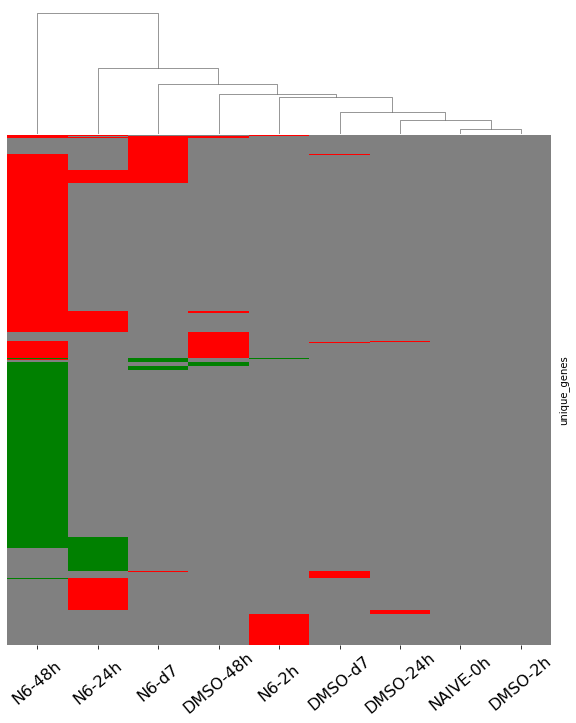

In [ ]:
all_genes = adata.var_names
hmdata = pd.DataFrame(index=all_genes)

for i in range(len(samp_list)):
    pvt = qthresholds[i] # p value threshold

    hmdata[samp_list[i]] = 0
    for gene in coex_result[i][(coex_result[i].qval < pvt) & (coex_result[i]['mean'] > fct)]['gene'].tolist():
        hmdata.loc[gene, samp_list[i]] = 1
    for gene in coex_result[i][(coex_result[i].qval < pvt) & (coex_result[i]['mean'] < - fct)]['gene'].tolist():
        hmdata.loc[gene, samp_list[i]] = -1
sig = np.sum(abs(hmdata), axis = 1)
hmdata = hmdata[sig > 0]
filt = [e == e for e in hmdata.index]
hmdata = hmdata[filt]

from matplotlib import colors
cmap = colors.ListedColormap(['green','grey','red'])
plot = sb.clustermap(hmdata, yticklabels=False, vmin = -1, vmax = 1, cmap = cmap, cbar_pos = None)
plot.ax_row_dendrogram.set_visible(False)
plot.ax_row_dendrogram.set_xlim([0,0])
plt.setp(plot.ax_heatmap.xaxis.get_majorticklabels(), rotation=40, va="center", position=(0,-0.06), size = 16)
plot.savefig("figures/coex_heatmap"+"_"+MARKER+".png")

In [ ]:
r24 = pd.read_excel("figures/coex_"+"N6-24h"+"_Il10.xlsx", sheet_name = "significant")
r48 = pd.read_excel("figures/coex_"+"N6-48h"+"_Il10.xlsx", sheet_name = "significant")
rd7 = pd.read_excel("figures/coex_"+"N6-d7"+"_Il10.xlsx", sheet_name = "significant")
dmso = pd.read_excel("figures/coex_"+"DMSO-48h"+"_Il10.xlsx", sheet_name = "significant")
inter_res = r48[(r48.gene.isin(r24.gene.tolist())) & (r48.gene.isin(rd7.gene.tolist())) & (~r48.gene.isin(dmso.gene.tolist()))]

results = inter_res
pvt = qthresholds[7] # p value threshold

deg = results[(results.qval < pvt) & (abs(results['mean']) > fct)].gene.tolist()
deg_up = results[(results.qval < pvt) & (results['mean'] > fct)].gene.tolist()
deg_down = results[(results.qval < pvt) & (results['mean'] < -fct)].gene.tolist()

if len(deg) > 10:
    enr = gp.enrichr(gene_list=deg,
                    gene_sets=['GO_Biological_Process_2021'], #, 'GO_Biological_Process_2021', 'GO_Molecular_Function_2021', 'GO_Cellular_Component_2021'
                    organism='Mouse', 
                    description='DEGs',
                    outdir='enr_plots/enr_DEGs',
                    cutoff=0.1,
                    format='png',
                    background='all_genes'
                    )
    if sum(enr.res2d['Adjusted P-value'] < 0.1) > 0:
        p = dotplot(enr.res2d[enr.res2d['Adjusted P-value'] < 0.1],title="inter",cmap='viridis_r', column='Combined Score', legend = False, ofname = "enr_plots/"+"inter"+"_"+MARKER+".png")

fname = "figures/coex_"+"inter"+"_"+MARKER+".xlsx"
writer = pd.ExcelWriter(fname, engine='xlsxwriter')

results.to_excel(writer, "everything")
results[results.qval < a].to_excel(writer, "significant")


TFA = results[(results["gene"].isin(tf_list)) & (results["qval"]<pvt) & (abs(results['mean']) > fct)]
TFA.index = range(len(TFA))
TFB = TFA.reindex(index = range(len(TFA)+1))
TFC = results[(results["gene"].isin(tf_list)) & ~((results["qval"]<pvt) & (abs(results['mean']) > fct))]
pd.concat([TFB, TFC], ignore_index=True).to_excel(writer, "transcrip° factor")

for j in range(len(diseases)):
    pd.DataFrame([diseases[j]]).to_excel(writer, "GWAS", startrow=0, startcol = j*4, header = False, index = False)
    results[(results["gene"].isin(GWAS[diseases[j]])) & (results["qval"]<pvt) & (abs(results['mean']) > fct)][['gene', 'mean']].to_excel(writer, 
        "GWAS", startrow=1, startcol = j*4)
j += 1
subsetted = results[(results["qval"]<pvt) & (abs(results['mean']) > fct)][['gene', 'mean']]
subsetted['GWAS'] = sum([(subsetted['gene'].isin(GWAS[k])) for k in GWAS.keys()])
subsetted[subsetted.GWAS >= 2][['gene', 'mean']].to_excel(writer, 
        "GWAS", startrow=1, startcol = j*4)

pd.DataFrame(["UP : More accessible in N6 D2-D3"]).to_excel(writer, "ATAC", startrow=0, startcol = 0, header = False, index = False)
atacD2_D3[atacD2_D3.gene.isin(deg_up)].to_excel(writer, "ATAC", startrow=1, startcol=0)
pd.DataFrame(["UP : More accessible in N6 D2-D3-D7"]).to_excel(writer, "ATAC", startrow=0, startcol = 9, header = False, index = False)
atacD2_D3_D7[atacD2_D3_D7.gene.isin(deg_up)].to_excel(writer, "ATAC", startrow=1, startcol=9)
M = max( len(atacD2_D3[atacD2_D3.gene.isin(deg_up)]), len(atacD2_D3_D7[atacD2_D3_D7.gene.isin(deg_up)]) )
pd.DataFrame(["DOWN : More accessible in N6 D2-D3"]).to_excel(writer, "ATAC", startrow=3+M, startcol = 0, header = False, index = False)
atacD2_D3[atacD2_D3.gene.isin(deg_down)].to_excel(writer, "ATAC", startrow=1, startcol=4+M)
pd.DataFrame(["DOWN : More accessible in N6 D2-D3-D7"]).to_excel(writer, "ATAC", startrow=3+M, startcol = 9, header = False, index = False)
atacD2_D3_D7[atacD2_D3_D7.gene.isin(deg_down)].to_excel(writer, "ATAC", startrow=1, startcol=4+M)

if len(deg) > 10:
    enr.results = enr.results[['Term', 'Overlap', 'Adjusted P-value', 'Odds Ratio', 'Combined Score', 'Genes']]
    enr.results = enr.results[enr.results['Adjusted P-value'] < 0.1]
    enr.results.sort_values(by="Combined Score", ascending=False).to_excel(writer, "enriched", index=False)

book = writer.book
imgsheet = book.add_worksheet('Enrichment')
if len(deg) > 10:
    if sum(enr.res2d['Adjusted P-value'] < 0.1) > 0:
        imgsheet.insert_image('B2', "enr_plots/"+"inter"+"_"+MARKER+".png")

writer.save()